In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from deq_vdp.core import ShallowFCN, DEQFixedPoint
from deq_vdp.solver import anderson

/home/bruno/miniconda3/envs/deq-vdp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Target definition

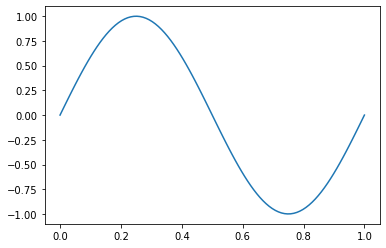

In [2]:
# f_real = lambda t: np.sin(10*t*np.pi) * np.sin(t*np.pi)
f_real = lambda t: np.sin(t*2*np.pi)

X = np.linspace(0, 1, 100)
y = f_real(X)
plt.plot(X, y)
plt.show()

X = torch.Tensor(X).unsqueeze(-1)
y = torch.Tensor(y).unsqueeze(-1)

# Training

100%|███████████████████████████████████████| 5000/5000 [11:39<00:00,  7.14it/s]


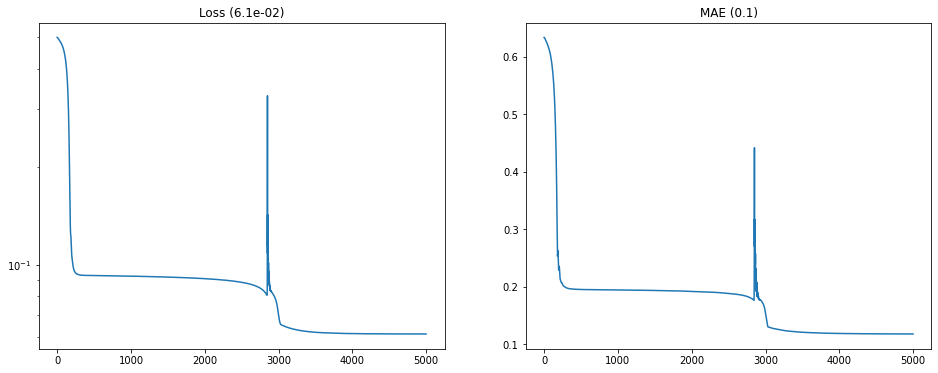

CPU times: user 22min 57s, sys: 6.84 s, total: 23min 4s
Wall time: 11min 40s


In [44]:
%%time
n_z = 8
f = ShallowFCN(n_states=n_z, input_size=1).float()
model = nn.Sequential(
    DEQFixedPoint(f, anderson, tol=1e-6, max_iter=500),
    nn.Linear(n_z,1),
    nn.Sigmoid(),
)
h = lambda x: 2 * x - 1

loss_f = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)

maes = list()
losses = list()
y_preds = list()

for e in tqdm(list(range(5000))):
    model.train()
    optimizer.zero_grad()

    y_pred = h(model(X))

    loss = loss_f(y_pred, y)

    loss.backward()
    optimizer.step()
#     scheduler.step(loss.item())

    losses.append(loss.item())
    y_preds.append(y_pred.detach().numpy())
    maes.append(
        (y_pred - y).abs().mean().detach().numpy()
    )

fig, axs = plt.subplots(1,2)
fig.set_size_inches(16,6)

axs[0].semilogy(losses)
axs[0].set_title(f"Loss ({losses[-1]:.1e})")

axs[1].plot(maes)
axs[1].set_title(f"MAE ({maes[-1]:.1f})")

plt.show()

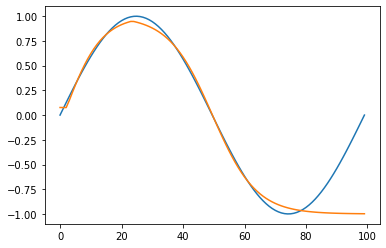

In [46]:
plt.plot(y.numpy())
plt.plot(y_preds[-1])